# Deep Convolutional Generative Adversarial Network (DCGAN) Tutorial

This tutorials walks through an implementation of DCGAN as described in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

To learn more about generative adversarial networks, see my [Medium post](https://medium.com/p/54deab2fce39) on them.

In [6]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically. It can be acquired Github here: https://gist.github.com/awjuliani/1d21151bc17362bf6738c3dc02f37906

In [7]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 28, 28)
(55000,)


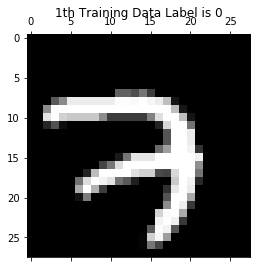

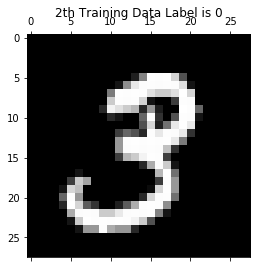

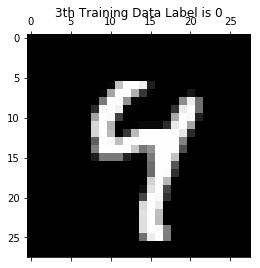

In [8]:
#print out several data in mnist
trainimg = mnist.train.images
train_y = mnist.train.labels
nsample = 1
randidx = np.random.randint(trainimg.shape[0], size=nsample)

train_x = np.reshape(trainimg,(trainimg.shape[0],28,28))
print(train_x.shape)
print(train_y.shape)

for i in [0, 1, 2]:
    curr_img   = np.reshape(trainimg[i, :], (28, 28)) # 28 by 28 matrix 
    curr_label = np.argmax(train_y[i] ) # Label
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title("" + str(i + 1) + "th Training Data " 
              + "Label is " + str(curr_label))

### Helper Functions

In [9]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided  transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [ ]:
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    print(g_out.shape)
    return g_out

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [ ]:
def discriminator(bottom, reuse=False):
    
    dis1 = slim.convolution2d(bottom,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis3),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

### Connecting them together

In [12]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
Now that we have fully defined our network, it is time to train it!

In [ ]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Gen Loss: 0.35994864 Disc Loss: 1.3788525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Gen Loss: 0.2513347 Disc Loss: 2.2086105
Gen Loss: 0.28645283 Disc Loss: 2.0941005
Gen Loss: 0.30712283 Disc Loss: 2.2060652
Gen Loss: 0.50348747 Disc Loss: 1.6525129
Gen Loss: 0.7374356 Disc Loss: 1.41066
Gen Loss: 0.90231276 Disc Loss: 1.2203984
Gen Loss: 0.406354 Disc Loss: 2.0701973
Gen Loss: 0.70255315 Disc Loss: 1.709961
Gen Loss: 0.7113926 Disc Loss: 1.5609004
Gen Loss: 0.7925967 Disc Loss: 1.4398818
Gen Loss: 0.746724 Disc Loss: 1.6430948
Gen Loss: 0.50436634 Disc Loss: 1.8229132
Gen Loss: 0.8415106 Disc Loss: 1.4333266
Gen Loss: 0.8891657 Disc Loss: 1.399858
Gen Loss: 0.9788276 Disc Loss: 1.3105829
Gen Loss: 0.8510064 Disc Loss: 1.54477
Gen Loss: 0.74704635 Disc Loss: 1.4666646
Gen Loss: 0.902571 Disc Loss: 1.2750053
Gen Loss: 0.6127502 Disc Loss: 1.4065369
Gen Loss: 0.983534 Disc Loss: 1.1213442
Gen Loss: 1.0616038 Disc Loss: 1.2264447
Gen Loss: 0.6658243 Disc Loss: 1.4056976
Gen Loss: 0.72334397 Disc Loss: 1.5525788
Gen Loss: 0.76751405 Disc Loss: 1.344102
Gen Loss: 1.069597

Saved Model
Gen Loss: 1.3825021 Disc Loss: 0.7187925
Gen Loss: 1.9849582 Disc Loss: 0.56525373
Gen Loss: 1.0633316 Disc Loss: 1.2198915
Gen Loss: 1.475823 Disc Loss: 0.7501813
Gen Loss: 1.2562666 Disc Loss: 1.1031849
Gen Loss: 1.538796 Disc Loss: 0.5306483
Gen Loss: 1.2942185 Disc Loss: 0.46653476
Gen Loss: 1.1726097 Disc Loss: 0.8009689
Gen Loss: 1.5488459 Disc Loss: 1.1253797
Gen Loss: 1.9334221 Disc Loss: 0.6548941
Gen Loss: 1.7166858 Disc Loss: 0.6417223
Gen Loss: 1.3932145 Disc Loss: 0.97349745
Gen Loss: 2.0378728 Disc Loss: 1.0078579
Gen Loss: 1.5094173 Disc Loss: 0.63716877
Gen Loss: 1.294667 Disc Loss: 0.61795473
Gen Loss: 1.3947573 Disc Loss: 0.7634151
Gen Loss: 1.2575344 Disc Loss: 1.148956
Gen Loss: 1.5184761 Disc Loss: 1.0150765
Gen Loss: 1.1381464 Disc Loss: 0.673231
Gen Loss: 1.8928809 Disc Loss: 0.54351866
Gen Loss: 0.94638425 Disc Loss: 1.0067278
Gen Loss: 2.088902 Disc Loss: 0.74465334
Gen Loss: 1.1905525 Disc Loss: 0.94976485
Gen Loss: 1.3445051 Disc Loss: 1.0698009
G

Gen Loss: 1.6706376 Disc Loss: 0.51018775
Saved Model
Gen Loss: 1.402487 Disc Loss: 0.6619989
Gen Loss: 1.3422116 Disc Loss: 0.83510566
Gen Loss: 1.9741824 Disc Loss: 0.55954766
Gen Loss: 1.6745286 Disc Loss: 0.70433766
Gen Loss: 1.349449 Disc Loss: 0.8268585
Gen Loss: 1.0674098 Disc Loss: 0.8384784
Gen Loss: 1.4938362 Disc Loss: 0.7057278
Gen Loss: 1.5300132 Disc Loss: 0.6580293
Gen Loss: 1.3935472 Disc Loss: 0.65251553
Gen Loss: 1.4737415 Disc Loss: 0.7364706
Gen Loss: 1.5018735 Disc Loss: 0.71946144
Gen Loss: 1.2254057 Disc Loss: 0.48277375
Gen Loss: 1.885452 Disc Loss: 0.86322993
Gen Loss: 1.1881137 Disc Loss: 0.9755726
Gen Loss: 1.8509564 Disc Loss: 0.7048449
Gen Loss: 1.6175169 Disc Loss: 0.6851474
Gen Loss: 1.8780341 Disc Loss: 0.61132115
Gen Loss: 1.000071 Disc Loss: 1.010999
Gen Loss: 1.3510289 Disc Loss: 0.8336716
Gen Loss: 1.4677942 Disc Loss: 0.8287361
Gen Loss: 2.0486205 Disc Loss: 0.69555384
Gen Loss: 1.8016527 Disc Loss: 1.1383858
Gen Loss: 1.3338268 Disc Loss: 0.7676314

In [ ]:
##Restore model

batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 500000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.
saver = tf.train.Saver()

with tf.Session() as sess:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)

print("Check path restored: {}".format(ckpt.model_checkpoint_path))

saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-4000.cptk
Check path restored: ./models/model-4000.cptk
Gen Loss: 0.34026134 Disc Loss: 1.4102767


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Gen Loss: 0.17839465 Disc Loss: 2.455771
Gen Loss: 0.37200192 Disc Loss: 2.0568995
Gen Loss: 0.38200635 Disc Loss: 1.8379753
Gen Loss: 0.58714247 Disc Loss: 1.6203126
Gen Loss: 0.74211144 Disc Loss: 1.3357854
Gen Loss: 0.46864507 Disc Loss: 1.9015648
Gen Loss: 0.59454477 Disc Loss: 1.7384622
Gen Loss: 0.6795434 Disc Loss: 1.6136096
Gen Loss: 0.88233376 Disc Loss: 1.4554856
Gen Loss: 0.68181324 Disc Loss: 1.6627884
Gen Loss: 0.6283709 Disc Loss: 1.6164323
Gen Loss: 0.69476426 Disc Loss: 1.6171007
Gen Loss: 0.87536526 Disc Loss: 1.2573495
Gen Loss: 0.74688494 Disc Loss: 1.4172904
Gen Loss: 0.9210396 Disc Loss: 1.3570906
Gen Loss: 0.933957 Disc Loss: 1.2534671
Gen Loss: 0.8382134 Disc Loss: 1.5236391
Gen Loss: 0.8920829 Disc Loss: 1.0216863
Gen Loss: 0.86307436 Disc Loss: 1.3188179
Gen Loss: 0.8699696 Disc Loss: 1.5976117
Gen Loss: 1.1849629 Disc Loss: 0.96415526
Gen Loss: 1.2287666 Disc Loss: 0.9009979
Gen Loss: 0.6077124 Disc Loss: 2.0944219
Gen Loss: 1.3771946 Disc Loss: 0.783043
Gen L

Saved Model
Gen Loss: 1.0141912 Disc Loss: 1.0411097
Gen Loss: 1.0178632 Disc Loss: 1.1036109
Gen Loss: 1.4257231 Disc Loss: 1.0505579
Gen Loss: 1.1132791 Disc Loss: 1.1600937
Gen Loss: 1.8225459 Disc Loss: 0.8438699
Gen Loss: 1.5519073 Disc Loss: 0.96170914
Gen Loss: 1.0704777 Disc Loss: 1.1888698
Gen Loss: 1.21122 Disc Loss: 0.8795947
Gen Loss: 1.3925236 Disc Loss: 1.1855863
Gen Loss: 1.2126238 Disc Loss: 0.8298856
Gen Loss: 0.9952308 Disc Loss: 0.89372563
Gen Loss: 1.1419191 Disc Loss: 1.3086778
Gen Loss: 1.3926362 Disc Loss: 0.89023066
Gen Loss: 0.8537656 Disc Loss: 0.85432136
Gen Loss: 1.2703197 Disc Loss: 0.9614876
Gen Loss: 2.0447016 Disc Loss: 0.7488069
Gen Loss: 1.4445777 Disc Loss: 0.7714686
Gen Loss: 1.5467151 Disc Loss: 1.0348392
Gen Loss: 1.269963 Disc Loss: 0.7923387
Gen Loss: 2.1034086 Disc Loss: 1.1435683
Gen Loss: 1.1867912 Disc Loss: 0.8522686
Gen Loss: 1.2005758 Disc Loss: 0.8741938
Gen Loss: 1.1594133 Disc Loss: 0.9144604
Gen Loss: 1.1236792 Disc Loss: 1.0889058
Gen

Gen Loss: 1.7431452 Disc Loss: 0.6920464
Saved Model
Gen Loss: 1.2642957 Disc Loss: 0.72012836
Gen Loss: 1.6531836 Disc Loss: 0.6460991
Gen Loss: 0.79102254 Disc Loss: 0.996485
Gen Loss: 1.7863541 Disc Loss: 0.6073317
Gen Loss: 2.5247333 Disc Loss: 0.70827854
Gen Loss: 2.041359 Disc Loss: 0.4746471
Gen Loss: 1.6945969 Disc Loss: 0.69805264
Gen Loss: 1.8761233 Disc Loss: 0.66147506
Gen Loss: 1.8448207 Disc Loss: 0.71608365
Gen Loss: 1.6463387 Disc Loss: 0.54050535
Gen Loss: 1.1970401 Disc Loss: 0.33921444
Gen Loss: 1.6396873 Disc Loss: 0.65794516
Gen Loss: 2.1225758 Disc Loss: 0.42269123
Gen Loss: 1.804924 Disc Loss: 0.7118256
Gen Loss: 1.5688885 Disc Loss: 0.8572037
Gen Loss: 1.703374 Disc Loss: 0.6338552
Gen Loss: 1.5828371 Disc Loss: 0.6723751
Gen Loss: 1.0914005 Disc Loss: 1.1041977
Gen Loss: 1.4268081 Disc Loss: 0.77069974
Gen Loss: 1.6141547 Disc Loss: 0.6469015
Gen Loss: 1.5682391 Disc Loss: 0.62017906
Gen Loss: 1.7451636 Disc Loss: 0.8635397
Gen Loss: 1.336637 Disc Loss: 0.65208

Gen Loss: 1.6973872 Disc Loss: 0.3843155
Gen Loss: 1.548768 Disc Loss: 0.49810147
Saved Model
Gen Loss: 1.1716857 Disc Loss: 0.86712235
Gen Loss: 1.4419622 Disc Loss: 0.71864355
Gen Loss: 2.119411 Disc Loss: 0.41023088
Gen Loss: 1.5008266 Disc Loss: 0.6386557
Gen Loss: 1.8662924 Disc Loss: 0.5561259
Gen Loss: 1.0574772 Disc Loss: 0.8801
Gen Loss: 1.9292443 Disc Loss: 0.60773647
Gen Loss: 0.8712327 Disc Loss: 0.8878626
Gen Loss: 1.2995176 Disc Loss: 0.6694714
Gen Loss: 2.1130505 Disc Loss: 0.64942884
Gen Loss: 1.7142953 Disc Loss: 0.8430763
Gen Loss: 1.3501395 Disc Loss: 0.7600859
Gen Loss: 0.8698276 Disc Loss: 0.9158566
Gen Loss: 1.2368702 Disc Loss: 0.7309933
Gen Loss: 2.758857 Disc Loss: 0.8848891
Gen Loss: 0.7470137 Disc Loss: 0.9642168
Gen Loss: 1.263458 Disc Loss: 0.7769774
Gen Loss: 1.4551795 Disc Loss: 0.6421734
Gen Loss: 1.0822322 Disc Loss: 0.720975
Gen Loss: 1.5443219 Disc Loss: 1.0492697
Gen Loss: 1.85884 Disc Loss: 0.6307593
Gen Loss: 1.3981997 Disc Loss: 0.7099513
Gen Loss

Gen Loss: 1.7524124 Disc Loss: 0.5401174
Gen Loss: 2.0204003 Disc Loss: 0.43719688
Gen Loss: 2.8860607 Disc Loss: 0.64384425
Saved Model
Gen Loss: 0.86825466 Disc Loss: 0.73003393
Gen Loss: 1.4042026 Disc Loss: 0.40759978
Gen Loss: 1.8297575 Disc Loss: 0.5463712
Gen Loss: 1.7270975 Disc Loss: 0.47988647
Gen Loss: 2.2000782 Disc Loss: 0.4561879
Gen Loss: 2.5348015 Disc Loss: 0.56865144
Gen Loss: 2.0236716 Disc Loss: 0.5597298
Gen Loss: 2.1702018 Disc Loss: 0.4927497
Gen Loss: 1.1652663 Disc Loss: 0.51176614
Gen Loss: 2.0084379 Disc Loss: 0.39736986
Gen Loss: 2.4757166 Disc Loss: 0.5092572
Gen Loss: 2.2246847 Disc Loss: 0.47991848
Gen Loss: 2.4002767 Disc Loss: 0.48660892
Gen Loss: 1.5603805 Disc Loss: 0.7213458
Gen Loss: 1.4573622 Disc Loss: 0.6762637
Gen Loss: 1.3852448 Disc Loss: 0.5748154
Gen Loss: 2.347486 Disc Loss: 0.50893146
Gen Loss: 1.9470081 Disc Loss: 0.55028707
Gen Loss: 2.0036013 Disc Loss: 0.56397796
Gen Loss: 1.5990586 Disc Loss: 0.8885504
Gen Loss: 1.4343748 Disc Loss: 0

Gen Loss: 1.5777245 Disc Loss: 0.39658305
Gen Loss: 1.9336648 Disc Loss: 0.49610874
Gen Loss: 1.5595227 Disc Loss: 0.41308063
Gen Loss: 1.6340063 Disc Loss: 0.5479597
Gen Loss: 1.9801968 Disc Loss: 0.53245914
Saved Model
Gen Loss: 1.5531282 Disc Loss: 0.8648921
Gen Loss: 3.165483 Disc Loss: 0.9103898
Gen Loss: 2.885889 Disc Loss: 0.4827976
Gen Loss: 0.8911561 Disc Loss: 0.80304456
Gen Loss: 1.6666343 Disc Loss: 0.7388113
Gen Loss: 1.3169351 Disc Loss: 0.7215553
Gen Loss: 2.0462904 Disc Loss: 0.31887555
Gen Loss: 1.23312 Disc Loss: 0.6991779
Gen Loss: 2.3622236 Disc Loss: 0.5219698
Gen Loss: 1.5810344 Disc Loss: 0.57075113
Gen Loss: 1.642488 Disc Loss: 0.7313498
Gen Loss: 1.2802267 Disc Loss: 0.45800322
Gen Loss: 1.8916118 Disc Loss: 0.47717857
Gen Loss: 2.3787408 Disc Loss: 0.36328268
Gen Loss: 1.4556806 Disc Loss: 0.43857875
Gen Loss: 2.368067 Disc Loss: 0.6850858
Gen Loss: 2.013865 Disc Loss: 0.44689393
Gen Loss: 2.0062711 Disc Loss: 0.67046106
Gen Loss: 1.9874117 Disc Loss: 0.569967

Gen Loss: 3.898579 Disc Loss: 0.96983576
Gen Loss: 2.220493 Disc Loss: 0.44817913
Gen Loss: 1.8721656 Disc Loss: 0.5801199
Gen Loss: 3.067791 Disc Loss: 0.28059405
Gen Loss: 4.0631413 Disc Loss: 0.3840367
Gen Loss: 2.2990918 Disc Loss: 0.44636756
Gen Loss: 2.7093735 Disc Loss: 0.5336031
Saved Model
Gen Loss: 1.8677282 Disc Loss: 0.6611341
Gen Loss: 0.8887445 Disc Loss: 1.5559403
Gen Loss: 1.7203877 Disc Loss: 0.56179804
Gen Loss: 1.6881505 Disc Loss: 0.77450734
Gen Loss: 1.1412861 Disc Loss: 0.90534496
Gen Loss: 2.2407231 Disc Loss: 0.5225805
Gen Loss: 1.8282797 Disc Loss: 0.48509896
Gen Loss: 1.7027473 Disc Loss: 0.41266686
Gen Loss: 1.6957462 Disc Loss: 0.6003778
Gen Loss: 3.250936 Disc Loss: 0.26202816
Gen Loss: 2.6481395 Disc Loss: 0.34613222
Gen Loss: 1.8094337 Disc Loss: 0.7694996
Gen Loss: 1.6790249 Disc Loss: 0.53338325
Gen Loss: 1.9490378 Disc Loss: 0.7037194
Gen Loss: 2.3206959 Disc Loss: 0.5729754
Gen Loss: 1.5597215 Disc Loss: 0.6738552
Gen Loss: 2.0057511 Disc Loss: 0.4427

Gen Loss: 1.5331084 Disc Loss: 0.43051308
Gen Loss: 1.6445282 Disc Loss: 0.5845008
Gen Loss: 1.2999284 Disc Loss: 0.5974597
Gen Loss: 1.3647932 Disc Loss: 0.6932093
Gen Loss: 2.5585232 Disc Loss: 0.45390773
Gen Loss: 1.340274 Disc Loss: 0.7512668
Gen Loss: 2.2190113 Disc Loss: 0.52344877
Gen Loss: 1.6225678 Disc Loss: 0.55626744
Gen Loss: 2.1364923 Disc Loss: 0.44275355
Saved Model
Gen Loss: 1.5152103 Disc Loss: 0.3489771
Gen Loss: 1.3878253 Disc Loss: 0.5116005
Gen Loss: 1.7618902 Disc Loss: 0.49960035
Gen Loss: 2.0607262 Disc Loss: 0.4224522
Gen Loss: 1.5736225 Disc Loss: 0.45063072
Gen Loss: 1.981407 Disc Loss: 0.39632314
Gen Loss: 1.70213 Disc Loss: 0.48986945
Gen Loss: 1.6630691 Disc Loss: 0.5439987
Gen Loss: 1.1213958 Disc Loss: 0.5942762
Gen Loss: 2.2619462 Disc Loss: 0.4074024
Gen Loss: 1.0192571 Disc Loss: 0.59956205
Gen Loss: 2.2107706 Disc Loss: 0.3662941
Gen Loss: 1.6451342 Disc Loss: 0.5120221
Gen Loss: 1.0837855 Disc Loss: 0.7645969
Gen Loss: 1.3689387 Disc Loss: 0.722408

Gen Loss: 2.6859915 Disc Loss: 0.8681445
Gen Loss: 3.0190253 Disc Loss: 0.70820785
Gen Loss: 2.3101273 Disc Loss: 0.6382157
Gen Loss: 3.0595114 Disc Loss: 0.44213864
Gen Loss: 1.3771458 Disc Loss: 0.29656044
Gen Loss: 2.163669 Disc Loss: 0.25199386
Gen Loss: 1.3991226 Disc Loss: 0.65110105
Gen Loss: 1.3393215 Disc Loss: 0.6283588
Gen Loss: 2.362523 Disc Loss: 0.5757004
Gen Loss: 3.0869784 Disc Loss: 0.40838093
Gen Loss: 1.9588346 Disc Loss: 0.35323995
Saved Model
Gen Loss: 2.6899338 Disc Loss: 0.43550515
Gen Loss: 1.7335646 Disc Loss: 0.47906405
Gen Loss: 1.8219647 Disc Loss: 0.7250878
Gen Loss: 1.525115 Disc Loss: 0.666457
Gen Loss: 1.3355682 Disc Loss: 0.69036067
Gen Loss: 1.751615 Disc Loss: 0.41828656
Gen Loss: 1.9686189 Disc Loss: 0.43457907
Gen Loss: 2.1951947 Disc Loss: 0.39545566
Gen Loss: 1.6765091 Disc Loss: 0.6652697
Gen Loss: 1.7318761 Disc Loss: 0.43892652
Gen Loss: 1.780669 Disc Loss: 0.4844593
Gen Loss: 3.1998677 Disc Loss: 0.5269376
Gen Loss: 1.9056289 Disc Loss: 0.6358

Gen Loss: 0.9416335 Disc Loss: 0.54376614
Gen Loss: 2.5838547 Disc Loss: 0.44878504
Gen Loss: 1.0394797 Disc Loss: 0.49609208
Gen Loss: 3.2486405 Disc Loss: 0.54119796
Gen Loss: 2.216385 Disc Loss: 0.34087914
Gen Loss: 2.5163171 Disc Loss: 0.5689461
Gen Loss: 1.7796016 Disc Loss: 0.4987211
Gen Loss: 2.7848818 Disc Loss: 0.2929317
Gen Loss: 3.845325 Disc Loss: 0.9001979
Gen Loss: 1.9953046 Disc Loss: 0.36107907
Gen Loss: 1.9134834 Disc Loss: 0.3969513
Gen Loss: 2.0628476 Disc Loss: 0.30910444
Gen Loss: 1.7057495 Disc Loss: 0.45366532
Saved Model
Gen Loss: 1.7523122 Disc Loss: 0.37108508
Gen Loss: 1.690047 Disc Loss: 0.31974187
Gen Loss: 1.429312 Disc Loss: 0.55652267
Gen Loss: 1.5094229 Disc Loss: 0.4951867
Gen Loss: 2.0299802 Disc Loss: 0.77313936
Gen Loss: 1.002733 Disc Loss: 0.5491192
Gen Loss: 3.950348 Disc Loss: 1.1948941
Gen Loss: 1.4177723 Disc Loss: 0.5234995
Gen Loss: 1.6424083 Disc Loss: 0.9253025
Gen Loss: 1.8466611 Disc Loss: 0.53397167
Gen Loss: 1.1467617 Disc Loss: 0.43105

Gen Loss: 2.4102666 Disc Loss: 0.48983467
Gen Loss: 1.5265849 Disc Loss: 0.5346045
Gen Loss: 1.1762056 Disc Loss: 0.54697067
Gen Loss: 1.8262328 Disc Loss: 0.26936847
Gen Loss: 2.24503 Disc Loss: 0.30750233
Gen Loss: 1.090666 Disc Loss: 0.5533295
Gen Loss: 2.6032436 Disc Loss: 0.45271158
Gen Loss: 1.3251294 Disc Loss: 0.42545456
Gen Loss: 2.0661633 Disc Loss: 0.36693546
Gen Loss: 1.302928 Disc Loss: 0.5965891
Gen Loss: 2.1645656 Disc Loss: 0.40063512
Gen Loss: 2.0739527 Disc Loss: 0.3333357
Gen Loss: 2.0766435 Disc Loss: 0.22681762
Gen Loss: 2.4644148 Disc Loss: 0.19665372
Gen Loss: 1.8141401 Disc Loss: 0.3328393
Saved Model
Gen Loss: 3.6154594 Disc Loss: 0.27108502
Gen Loss: 2.3155828 Disc Loss: 0.30785257
Gen Loss: 1.9023044 Disc Loss: 0.3608256
Gen Loss: 1.6361878 Disc Loss: 0.32722676
Gen Loss: 1.5619571 Disc Loss: 0.60897255
Gen Loss: 3.1019073 Disc Loss: 0.3916878
Gen Loss: 1.5758023 Disc Loss: 0.5629133
Gen Loss: 2.2184355 Disc Loss: 0.39862308
Gen Loss: 1.4711599 Disc Loss: 0.5

Gen Loss: 2.127523 Disc Loss: 0.46083462
Gen Loss: 2.5831866 Disc Loss: 0.61534715
Gen Loss: 0.6445354 Disc Loss: 0.5759952
Gen Loss: 1.5031471 Disc Loss: 0.54028285
Gen Loss: 1.004962 Disc Loss: 0.28505567
Gen Loss: 2.2698874 Disc Loss: 0.43303347
Gen Loss: 2.2044368 Disc Loss: 0.41523522
Gen Loss: 1.0058892 Disc Loss: 0.7570899
Gen Loss: 2.1611533 Disc Loss: 0.79783034
Gen Loss: 2.0646367 Disc Loss: 0.41262656
Gen Loss: 1.9245782 Disc Loss: 0.5257066
Gen Loss: 1.652061 Disc Loss: 0.44083136
Gen Loss: 1.2270803 Disc Loss: 0.48959726
Gen Loss: 1.5854447 Disc Loss: 0.36728328
Gen Loss: 1.9903371 Disc Loss: 0.7221656
Gen Loss: 2.45937 Disc Loss: 0.3797338
Gen Loss: 1.5973637 Disc Loss: 0.6503397
Gen Loss: 3.2741487 Disc Loss: 0.7392428
Saved Model
Gen Loss: 3.2143497 Disc Loss: 0.23653135
Gen Loss: 1.8388638 Disc Loss: 0.37007368
Gen Loss: 2.4230309 Disc Loss: 0.2657847
Gen Loss: 1.8924452 Disc Loss: 0.40385243
Gen Loss: 1.8784822 Disc Loss: 0.45174703
Gen Loss: 2.3518481 Disc Loss: 0.48

Gen Loss: 2.9624867 Disc Loss: 0.4615981
Gen Loss: 1.9587061 Disc Loss: 0.4971751
Gen Loss: 2.235138 Disc Loss: 0.3533842
Gen Loss: 1.5694399 Disc Loss: 0.550723
Gen Loss: 2.8782012 Disc Loss: 0.45828342
Gen Loss: 1.3886855 Disc Loss: 0.48105353
Gen Loss: 0.8922701 Disc Loss: 0.6693362
Gen Loss: 1.4400401 Disc Loss: 0.56635356
Gen Loss: 1.0636674 Disc Loss: 0.4938355
Gen Loss: 1.3269564 Disc Loss: 0.55705893
Gen Loss: 1.8988138 Disc Loss: 0.46800023
Gen Loss: 3.0446787 Disc Loss: 0.4698226
Gen Loss: 0.9843877 Disc Loss: 0.7588086
Gen Loss: 1.3030407 Disc Loss: 0.6516006
Gen Loss: 2.081491 Disc Loss: 0.4198072
Gen Loss: 0.8562511 Disc Loss: 0.29731423
Gen Loss: 2.3146706 Disc Loss: 0.3635556
Gen Loss: 1.3690779 Disc Loss: 0.6286979
Gen Loss: 0.846349 Disc Loss: 0.12207113
Gen Loss: 4.583755 Disc Loss: 1.1914654
Saved Model
Gen Loss: 3.2151027 Disc Loss: 1.0728445
Gen Loss: 1.7143538 Disc Loss: 0.5083765
Gen Loss: 2.105441 Disc Loss: 0.4087685
Gen Loss: 1.4058399 Disc Loss: 0.7464466
Gen

Gen Loss: 2.1320372 Disc Loss: 0.54592097
Gen Loss: 2.1646347 Disc Loss: 0.34770268
Gen Loss: 2.5113087 Disc Loss: 0.59072775
Gen Loss: 2.7908044 Disc Loss: 0.43865505
Gen Loss: 3.021532 Disc Loss: 0.25929186
Gen Loss: 1.649095 Disc Loss: 0.4824612
Gen Loss: 1.7753918 Disc Loss: 0.42795724
Gen Loss: 2.6597788 Disc Loss: 0.58232325
Gen Loss: 2.1372068 Disc Loss: 0.3585409
Gen Loss: 1.9311303 Disc Loss: 0.4129011
Gen Loss: 2.4538653 Disc Loss: 0.6272513
Gen Loss: 1.5195049 Disc Loss: 0.4522054
Gen Loss: 1.3687463 Disc Loss: 0.6397522
Gen Loss: 1.0860442 Disc Loss: 0.52879816
Gen Loss: 2.4532537 Disc Loss: 0.54543114
Gen Loss: 1.4546089 Disc Loss: 0.52530885
Gen Loss: 1.6030574 Disc Loss: 0.4641875
Gen Loss: 1.4082032 Disc Loss: 0.5115786
Gen Loss: 1.905753 Disc Loss: 0.50346226
Gen Loss: 2.1420805 Disc Loss: 0.3909564
Gen Loss: 2.8299856 Disc Loss: 0.33508995
Gen Loss: 1.7046821 Disc Loss: 0.36661193
Saved Model
Gen Loss: 1.4311299 Disc Loss: 0.4023059
Gen Loss: 2.5899158 Disc Loss: 0.45

Gen Loss: 1.6398311 Disc Loss: 0.6716149
Gen Loss: 1.2119161 Disc Loss: 0.5483196
Gen Loss: 2.2346857 Disc Loss: 0.39218023
Gen Loss: 2.4155838 Disc Loss: 0.3587458
Gen Loss: 1.2254021 Disc Loss: 0.4444731
Gen Loss: 2.5052924 Disc Loss: 0.713041
Gen Loss: 2.1822395 Disc Loss: 0.36572143
Gen Loss: 0.47163337 Disc Loss: 1.3603964
Gen Loss: 1.5096579 Disc Loss: 0.63106894
Gen Loss: 1.6046371 Disc Loss: 0.4030887
Gen Loss: 2.0226529 Disc Loss: 0.5166544
Gen Loss: 1.5104291 Disc Loss: 0.45278573
Gen Loss: 1.4081322 Disc Loss: 0.7111559
Gen Loss: 1.7206423 Disc Loss: 0.5599481
Gen Loss: 0.5261354 Disc Loss: 1.0198103
Gen Loss: 1.1531017 Disc Loss: 0.5614096
Gen Loss: 1.2679703 Disc Loss: 0.4552105
Gen Loss: 1.7379733 Disc Loss: 0.59135073
Gen Loss: 1.0775784 Disc Loss: 0.8159417
Gen Loss: 2.347796 Disc Loss: 0.76649934
Gen Loss: 1.3320618 Disc Loss: 0.44679487
Gen Loss: 1.9492637 Disc Loss: 0.31912073
Gen Loss: 1.8383038 Disc Loss: 0.7252542
Gen Loss: 1.7539752 Disc Loss: 0.4913935
Saved Mod

Gen Loss: 1.0681207 Disc Loss: 0.43209177
Gen Loss: 1.9186256 Disc Loss: 0.33409303
Gen Loss: 2.1432831 Disc Loss: 0.2590255
Gen Loss: 1.7846345 Disc Loss: 0.28595644
Gen Loss: 1.715904 Disc Loss: 0.40765005
Gen Loss: 1.7957277 Disc Loss: 0.38481012
Gen Loss: 2.603773 Disc Loss: 0.24837881
Gen Loss: 2.0914378 Disc Loss: 0.2789882
Gen Loss: 1.8107007 Disc Loss: 0.39487338
Gen Loss: 1.611002 Disc Loss: 0.38265675
Gen Loss: 2.2716289 Disc Loss: 0.17021123
Gen Loss: 3.6671166 Disc Loss: 1.2987676
Gen Loss: 1.5372946 Disc Loss: 0.6055435
Gen Loss: 1.1646442 Disc Loss: 0.41603488
Gen Loss: 2.1813939 Disc Loss: 0.32646275
Gen Loss: 2.4173894 Disc Loss: 0.4023559
Gen Loss: 1.5518768 Disc Loss: 0.45540476
Gen Loss: 1.5668879 Disc Loss: 0.35341656
Gen Loss: 0.82128215 Disc Loss: 0.7113198
Gen Loss: 2.5780516 Disc Loss: 0.5933369
Gen Loss: 0.9055191 Disc Loss: 0.8485764
Gen Loss: 2.7670856 Disc Loss: 0.49396443
Gen Loss: 1.7487113 Disc Loss: 0.40301642
Gen Loss: 3.6441073 Disc Loss: 0.58106756
Ge

Gen Loss: 1.5421356 Disc Loss: 0.509973
Gen Loss: 2.207448 Disc Loss: 0.34704155
Gen Loss: 1.8020583 Disc Loss: 0.422564
Gen Loss: 1.6918199 Disc Loss: 0.22519892
Gen Loss: 1.2641094 Disc Loss: 0.58953667
Gen Loss: 1.8784556 Disc Loss: 0.43054113
Gen Loss: 1.2308192 Disc Loss: 0.53795195
Gen Loss: 3.17796 Disc Loss: 0.44522768
Gen Loss: 4.5504274 Disc Loss: 1.1792772
Gen Loss: 2.4507017 Disc Loss: 0.42620897
Gen Loss: 2.7226114 Disc Loss: 0.5861797
Gen Loss: 2.3937063 Disc Loss: 0.25309935
Gen Loss: 1.823317 Disc Loss: 0.5032739
Gen Loss: 2.0679426 Disc Loss: 0.49913728
Gen Loss: 2.3094087 Disc Loss: 0.4846728
Gen Loss: 1.7415612 Disc Loss: 0.3018358
Gen Loss: 1.648238 Disc Loss: 0.34237218
Gen Loss: 1.0853813 Disc Loss: 0.41392285
Gen Loss: 2.4787867 Disc Loss: 0.38848698
Gen Loss: 2.6320145 Disc Loss: 0.5331228
Gen Loss: 2.0773416 Disc Loss: 0.4123438
Gen Loss: 1.6528888 Disc Loss: 0.45821896
Gen Loss: 1.6101162 Disc Loss: 0.5620132
Gen Loss: 1.3372273 Disc Loss: 0.7627672
Gen Loss: 

Gen Loss: 1.1622882 Disc Loss: 0.8276273
Gen Loss: 1.2236116 Disc Loss: 0.57636166
Gen Loss: 2.9374535 Disc Loss: 0.97149444
Gen Loss: 0.62179124 Disc Loss: 0.9716643
Gen Loss: 2.835959 Disc Loss: 0.8308033
Gen Loss: 2.877152 Disc Loss: 0.7445181
Gen Loss: 1.0801587 Disc Loss: 0.6616997
Gen Loss: 1.3302858 Disc Loss: 0.42272425
Gen Loss: 1.4619497 Disc Loss: 0.55765814
Gen Loss: 3.1966436 Disc Loss: 0.9263127
Gen Loss: 1.5561253 Disc Loss: 0.48309177
Gen Loss: 1.188083 Disc Loss: 0.5637245
Gen Loss: 2.336227 Disc Loss: 0.6135638
Gen Loss: 1.8532736 Disc Loss: 0.3874627
Gen Loss: 1.1768982 Disc Loss: 0.3740883
Gen Loss: 1.3325891 Disc Loss: 0.53732395
Gen Loss: 1.2864323 Disc Loss: 0.5306049
Gen Loss: 1.25036 Disc Loss: 0.5733907
Gen Loss: 2.147855 Disc Loss: 0.41288298
Gen Loss: 1.4262334 Disc Loss: 0.38503903
Gen Loss: 2.1427052 Disc Loss: 0.3522855
Gen Loss: 2.4086266 Disc Loss: 0.41635692
Gen Loss: 0.96041536 Disc Loss: 0.605965
Gen Loss: 1.9688437 Disc Loss: 0.51617503
Gen Loss: 2.

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [ ]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')